# Proyecto Entregable 2: Análisis de mercado inmobiliario
# Ingeniería de features, Modelos avanzados e Interpretación de modelos

Estudiante: Mónica Lorena Ortiz Medina

**PARTE A - Transformación de Datos**

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:



1.   Detección y eliminación de Outliers
2.   Encoding
3.   Imputación de valores faltantes 
4.   Escalado de datos 
5.   Generación de nuevas variables predictoras/reducción de dimensionalidad (SDV/PCA)

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.


In [ ]:
#Librerías
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Base de datos de Properati

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/DS_Proyecto_01_Datos_Properati.csv")

# Cinco primeras instancias de la base de datos de Properati
df.head()

Mounted at /content/drive


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


**1. Generación de Variables**

Como primer paso se crean variables que podrían resultar útiles para la predicción del precio de la vivienda. Como hipótesis, se podría esperar que una venta rápida describe un valor justo dadas las características de la propiedad y su ubicación. Por esta razón la variable días, calculada como la diferencia entre la fecha de inicio de venta de la propiedad (start_date) y la finalización de compra del mismo (end_date), podría ser útil para este objetivo.

In [ ]:
from datetime import date
from datetime import datetime
df['end_date'] = pd.to_datetime(df['end_date'], infer_datetime_format=True, errors='coerce')
df['end_date'] = df['end_date'].astype('datetime64[ns]')
df['end_date'] = pd.to_datetime(df['end_date'])

In [ ]:
df['end_date']= pd.to_datetime(df['end_date'])
df['start_date']= pd.to_datetime(df['start_date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       146660 non-null  datetime64[ns]
 1   end_date         121559 non-null  datetime64[ns]
 2   created_on       146660 non-null  object        
 3   lat              136735 non-null  float64       
 4   lon              136701 non-null  float64       
 5   l1               146660 non-null  object        
 6   l2               146660 non-null  object        
 7   l3               146660 non-null  object        
 8   rooms            146660 non-null  float64       
 9   bedrooms         146660 non-null  float64       
 10  bathrooms        140703 non-null  float64       
 11  surface_total    126133 non-null  float64       
 12  surface_covered  125046 non-null  float64       
 13  price            146660 non-null  float64       
 14  currency         146

In [ ]:
df['dif_days']=df['end_date']- df['start_date']

In [ ]:
df['dif_days']=df['dif_days']/np.timedelta64(1,'D')

df.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,dif_days
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,67.0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,35.0


Por otro lado, palabras en el título de la propiedad podrían ser atractivas para los compradores. Analizando la base de datos se puede observar algunos de estos adjetivos: Espectacular, Lindo(a), Excelente, Impecable, Lindísimo(a), Precioso(a), entre otros. Por esta razón se crea la variable dummy en la que es "True" si la propiedad contine alguno de estos adjetivos.

In [ ]:
print(df['title'])

0               ***Venta semipiso centro, ideal hostel*****
1          Espectacular PH reciclado en Boedo sin expensas.
2         Depto.tipo casa de 2 ambientes en Venta en Pal...
3         COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...
4         58 entre 1 y 2  Venta de departamento en ph.1 ...
                                ...                        
146655    Departamento en Venta en Barrio Privado Barran...
146656    Venta departamentos tres dormitorios jardín co...
146657    Venta departamento de un ambiente Manzanares C...
146658             Departamento en Venta. Manzanares chico.
146659            Departamento en venta en Manzanares Chico
Name: title, Length: 146660, dtype: object


In [ ]:
df['adjetivos'] = df['title'].str.contains('Espectacular|Lindo|Precioso|Estrenar|Excelente|Impecable|Lindísimo|Lindísima|Preciosa|Linda|Hermoso|Hermosa|Organizado|Moderno', regex=True)
df.head(1)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,dif_days,adjetivos
0,2019-10-17,2019-12-23,2019-10-17,-34.60588,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,67.0,False


**2. Eliminación de datos**

Se eliminan algunas variables que para el propósito del ejercicio no son útiles como: fecha de inicio de la venta, finalización de la venta, creación del registro, latitud, longitud, l1 que indica el país de la propiedad y puesto que es Argentina en todos no aporta información relevante, el tipo de moneda que es dólares en todos los casos, el título y la descripción, así como la operación que para el caso actual deben ser todas ventas.

In [ ]:
columnas_eliminar=['end_date', 'start_date', 'created_on', 'lat', 'lon', 'l1', 'title', 'description', 'currency', 'operation_type']

df2= df.drop(columnas_eliminar, axis=1)
df2.shape

(146660, 11)

El nuevo dataset tiene 146.660 filas y 11 columnas/variables tras la eliminación de las variables indicadas. 

In [ ]:
df2.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dif_days,adjetivos
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,67.0,False
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,35.0,True
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,15.0,False
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,67.0,False
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,146.0,False


**3. Outliers**

Para que un modelo pueda generalizar en la predicción de la variable objetivo, que en este caso es precios, es importante hacer un análisis de los datos que son atípicos. Por esta razón a continuación se analiza la distribución que tienen los precios teniendo en cuenta los tipos de propiedad. 

La primera gráfica que se observa a continuación permite ver que valores superiores a 5 millones de dólares son atípicos y hay una concentración importante en precios inferiores a este valor. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


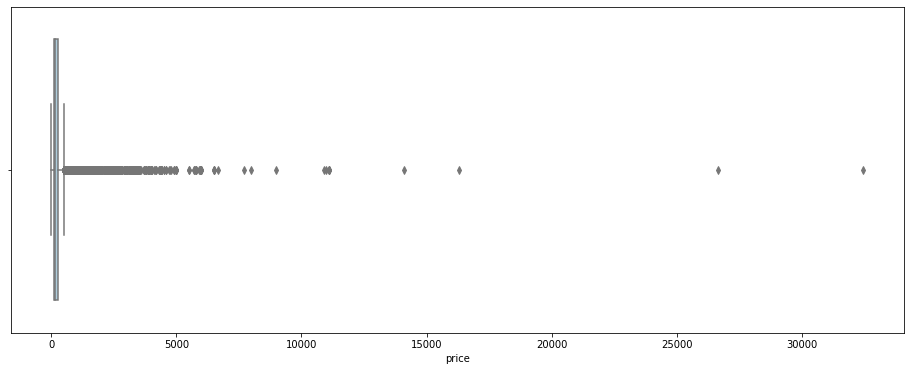

In [ ]:
plt.figure(figsize=(16,6))
graph_price=df2.price/1000  #Se divide entre mil para tener los precios en miles de dólares
sns.boxplot(graph_price, palette='Paired')

Del Proyecto 1 ya se tenía información de los outliers importantes que habían en el precio aún analizándolo por tipo de propiedad. En la gráfica a continuación es posible observar por ejemplo para departamento, existe un precio superior a los 30.000 millones de dólares, en el caso de la casa uno cercano a los 13.000 millones de dólares, y en otros tipos de propiedad valores cercanos a los 20.000 millones. 

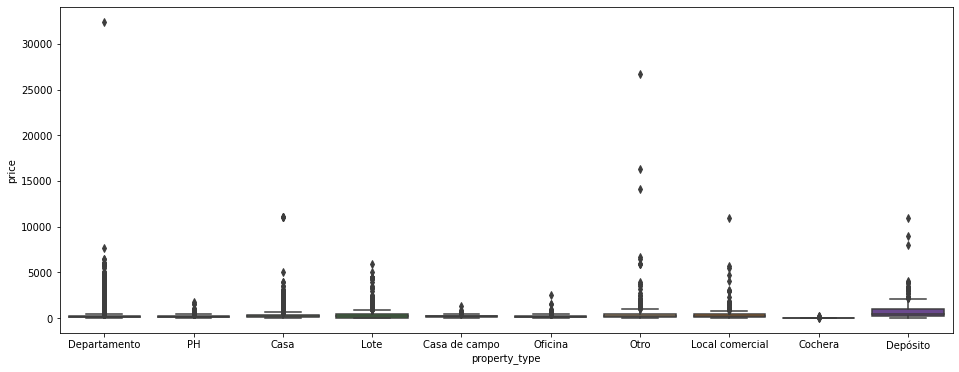

In [ ]:
plt.figure(figsize=(16,6))
graph_price=df2.price/1000  #Se divide entre mil para tener los precios en miles de dólares
sns.boxplot(y=graph_price, x=df2.property_type, palette='Paired')

Teniendo en cuenta los outliers impiden una buena generalización pues limitan el poder del modelo de predecir precios a datos atípicos que pueden ser errores en la inserción de datos o propiedades especiales. 

A continuación se procede a remover estos valores atípicos utilizando el rango intercuartilico.

In [ ]:
q1, q3 = df2['price'].quantile(0.25), df2['price'].quantile(0.75)
IQR = q3 - q1

upper = q3 + 1.5 * IQR
lower = q1 - 1.5 * IQR 

df3 = df2[(df2.price > lower) & (df2.price < upper)]

La gráfica a continuación permite ver con mayor claridad la distribución del precio por tipo de propiedad al eliminar los precios por encima del rango intercuartilico.

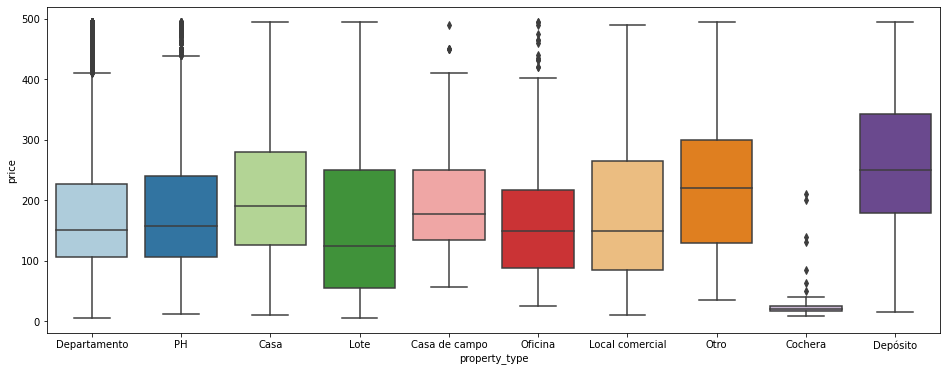

In [ ]:
plt.figure(figsize=(16,6))
graph_price1 = df3.price/1000
sns.boxplot(y = graph_price1, x = df3.property_type, palette='Paired')

La cercanía a cero en el boxplot inicial se explica en el gráfico a continuación en donde los valores se acercan más a los 120 mil dólares, que antes era imposible observar con claridad. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


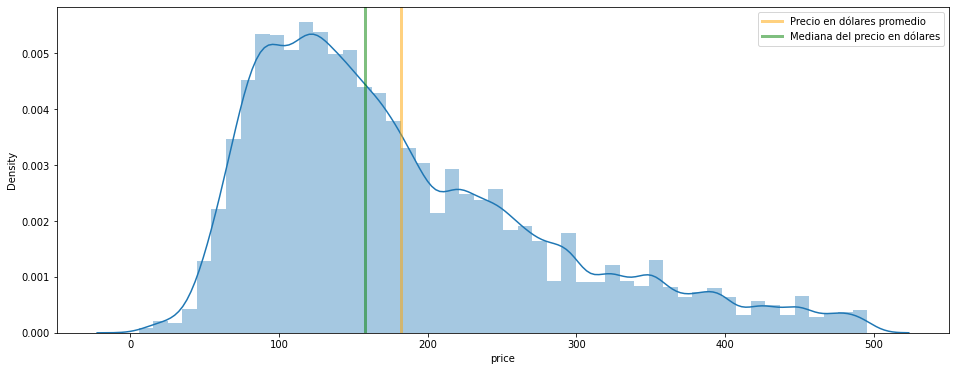

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(graph_price1)
plt.axvline(x=graph_price1.mean(), linewidth=3, color='orange', label="Precio en dólares promedio", alpha=0.5)
plt.axvline(x=graph_price1.median(), linewidth=3, color='green', label="Mediana del precio en dólares", alpha=0.5)
plt.legend()

Tras la limpieza de los atípicos en la variable target, el dataset se redujo en 7.994 filas (5,6%), al pasar de 143.660 a 135.666 filas. 

In [ ]:
df3.shape

(135666, 11)

**4. Valores faltantes/Missings**

Primero se estima el porcentaje de valores faltantes por cada columna que tiene la base de datos actual. En particular, y como ya se identificó en la Entrega 01, las variables de superficie total y cubierta tienen el mayor porcentaje de valores faltantes, seguido por el número de baños.

Por otro lado, la variable recién creada, 'dif_days', que contabiliza el tiempo en dáis transcurrido entre la fecha de publicación de venta de la propiedad y la venta efectiva de la misma tiene la mayor proporción de missings. 

En todo caso se procederá a imputar los valores teniendo en cuenta dos caracteríasticas del tipo de propiedad, imputando el valor de la media. 

In [ ]:
print("% missing values")
(df3.isna().sum()/len(df3))*100

% missing values


l2                  0.000000
l3                  0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           3.972255
surface_total      14.134713
surface_covered    14.839385
price               0.000000
property_type       0.000000
dif_days           17.254139
adjetivos           0.000000
dtype: float64

In [ ]:
df3.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dif_days,adjetivos
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,67.0,False
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,35.0,True
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,15.0,False
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,67.0,False
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,146.0,False


In [ ]:
#Dif_days
df3["dif_days"] = df3.groupby("property_type")["dif_days"].transform(
    lambda grp: grp.fillna(np.mean(grp)))


#Bathrooms
df3["bathrooms"] = df3.groupby("property_type")["bathrooms"].transform(
    lambda grp: grp.fillna(np.mean(grp)))

#Surface total
df3["surface_total"] = df3.groupby("property_type")["surface_total"].transform(
    lambda grp: grp.fillna(np.mean(grp)))

#Surface covered
df3["surface_covered"] = df3.groupby("property_type")["surface_covered"].transform(
    lambda grp: grp.fillna(np.mean(grp)))

df3.isna().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dif_days           0
adjetivos          0
dtype: int64

Del proyecto 1 se identificó que podría existir una inconsistencia en las variables de superficie, en donde la superficie cubierta no podría ser superior a la total. Con las limpiezas que se le han hecho a la base de datos hasta este punto del ejercicio existen 1.939 registros de propiedades que tienen esta inconsistencia. Para corregirlo se impuratá el valor de la superficie total a la que cumpla con esta inconsistencia y al menos no persistirá el error y se asumirá que en estas propiedades la superficie total es exactamente igual a la cubierta. 

In [ ]:
df3.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dif_days,adjetivos
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,67.0,False
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,35.0,True
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,15.0,False
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,67.0,False
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,146.0,False


In [ ]:
inconsistencia = df3["surface_covered"] > df3["surface_total"]
inconsistencia.sum()

1939

In [ ]:
df3.loc[df3["surface_covered"] > df3["surface_total"], "surface_covered"] = df3["surface_total"]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
#Comprobación de la corrección
inconsistencia2=df3["surface_covered"] > df3["surface_total"]
inconsistencia2.sum()

0

In [ ]:
df3.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dif_days,adjetivos
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,67.0,False
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,35.0,True
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,15.0,False
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,67.0,False
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,146.0,False


**5. Encoding**

Aquellas variables/columnas que tienen valores categóricos es importante tenerlas con una asignación numérica que permita incluirlas en los modelos. Variables como el barrio en el que está la propiedad son de gran relevancia para el análisis pues influye en las condiciones de entorno de la propiedad. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df3["property_type_en"] = ord_enc.fit_transform(df3[["property_type"]])
df3[["property_type", "property_type_en"]].head(11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,property_type,property_type_en
0,Departamento,3.0
1,PH,9.0
2,PH,9.0
3,PH,9.0
4,PH,9.0
5,PH,9.0
6,PH,9.0
7,PH,9.0
8,PH,9.0
9,PH,9.0


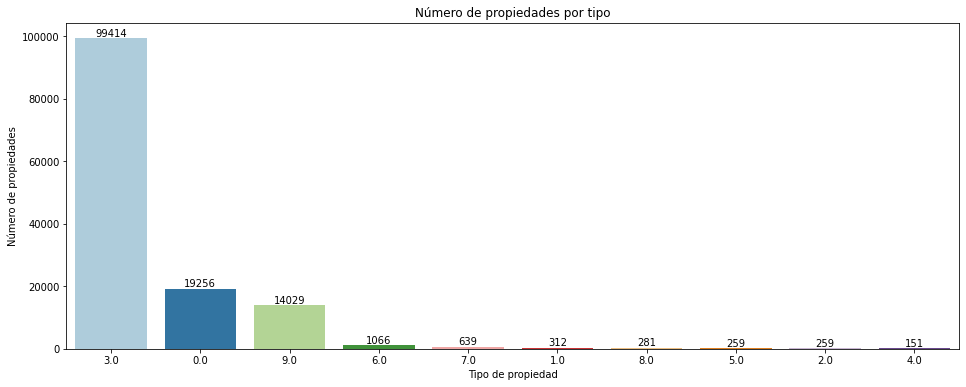

In [ ]:
#Conteo del número de propiedades por tipo
plt.figure(figsize=(16, 6))
#https://python-graph-gallery.com/python-colors/
#Paletas posibles: Spectral, Set2, Set3, RdPu, RdBu, PuRd, Accent, Paired
plot1=sns.countplot(data = df3, x = 'property_type_en', palette='Paired', order=df3['property_type_en'].value_counts().index)
plt.title("Número de propiedades por tipo")
plt.xlabel('Tipo de propiedad')
plt.ylabel('Número de propiedades')


for i in plot1.patches: 
  plot1.annotate(format(i.get_height()), (i.get_x()+i.get_width()/2., i.get_height()), ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.show()

In [ ]:
df3["l3_en"] = ord_enc.fit_transform(df3[["l3"]])
df3[["l3", "l3_en"]].head(11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,l3,l3_en
0,San Cristobal,63.0
1,Boedo,11.0
2,Palermo,48.0
3,Palermo,48.0
4,La Plata,33.0
5,Villa Crespo,76.0
6,Villa Crespo,76.0
7,Villa Crespo,76.0
8,Parque Patricios,53.0
9,Parque Patricios,53.0


In [ ]:
df3["adjetivos_en"] = ord_enc.fit_transform(df3[["adjetivos"]])
df3[["adjetivos", "adjetivos_en"]].head(11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,adjetivos,adjetivos_en
0,False,0.0
1,True,1.0
2,False,0.0
3,False,0.0
4,False,0.0
5,False,0.0
6,False,0.0
7,False,0.0
8,False,0.0
9,False,0.0


In [ ]:
columnas_eliminar1=['l2', 'l3', 'adjetivos', 'property_type']

df3.drop(columns=columnas_eliminar1, inplace=True)
df3.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(135666, 10)

In [ ]:
df3.head(100)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,dif_days,property_type_en,l3_en,adjetivos_en
0,7.0,7.0,2.0,140.0,140.0,153000.0,67.0,3.0,63.0,0.0
1,2.0,1.0,2.0,70.0,58.0,159000.0,35.0,9.0,11.0,1.0
2,2.0,1.0,1.0,45.0,45.0,125000.0,15.0,9.0,48.0,0.0
3,2.0,1.0,1.0,85.0,50.0,295000.0,67.0,9.0,48.0,0.0
4,2.0,1.0,1.0,50.0,35.0,40000.0,146.0,9.0,33.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,2.0,1.0,1.0,43.0,37.0,151500.0,5.0,3.0,18.0,1.0
96,2.0,1.0,1.0,43.0,40.0,95000.0,67.0,3.0,32.0,0.0
97,1.0,1.0,1.0,25.0,25.0,70000.0,127.0,3.0,32.0,0.0
98,2.0,1.0,1.0,48.0,48.0,165000.0,67.0,3.0,65.0,0.0


Traigo la limpieza del dataset utilizado en el Proyecto 1 

In [ ]:
#1. Propiedades en Capital Federal
temp = df[df['l2'].str.contains('Capital Federal')]

#1. Tipo de propiedad: Departamento, PH o Casa
select = ['Casa', 'Departamento', 'PH']
data_ml = temp[temp['property_type'].isin(select)] 

#2. Superficie total menor a 1000 m2 y mayor a 15 m2.
data_ml = data_ml[data_ml['surface_total'].between(15, 1000)]

#3. Precio menor 4.000.000 dólares
data_ml = data_ml[data_ml['price'].between(0, 4000000)]

#4. Selecciona las columnas rooms, bedrooms, bathrooms, surface_total, surface_covered y price (6 variables)
data_ml = data_ml[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']] 

#5. Descarta aquellas instancias con valores faltantes.
data_ml = data_ml.dropna() #drop missing values

In [ ]:
# X e y para el dataset del proyecto 1 
X_ml = data_ml.drop(["price"], axis=1)
y_ml = data_ml.price/1000

In [ ]:
#Realizar un Train/Test split de los datos
from sklearn.model_selection import train_test_split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, train_size=0.8,test_size=0.2, random_state=42)

In [ ]:
#X e y par el dataset limpio en los pasos 1-5
X_nd = df3.drop(["price"], axis = 1)
y_nd = df3.price / 1000

In [ ]:
#Realizar un Train/Test split de los datos
from sklearn.model_selection import train_test_split
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_nd, y_nd, train_size=0.8,test_size=0.2, random_state=42)

**Entrega 1 Conclusiones (Recordar)**

En la entrega del primer proyecto se hizo un modelo de árbol de decisión y vecinos más cercanos. Al final del proyecto se concluyó que el modelo de vecinos más cercano tenía la metodología más sencilla y una facilidad mayor para optimizar sus hiperparámetros. 



**Consigna:**

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

**1. Comparación con Regresión lineal**

Métricas: Error medio absoluto (MAE) que indica en promedio qué tanto se equivoca el modelo en su predicción del valor verdadero. Por otro lado el R2 o coeficiente de determinación indica la bondad de ajuste del modelo, entre más cercano a 1 indica que las variables independientes explican la variable dependiente o target. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
linear_regression = LinearRegression()

#Entrenamiento para los dos datasets
#New dataset
linear_regression.fit(X_train_nd, y_train_nd)
pred_nd = linear_regression.predict(X_test_nd)
#Dataset del royecto 1 
linear_regression.fit(X_train_ml, y_train_ml)
pred_ml = linear_regression.predict(X_test_ml)


#Métricas de evaluación de modelos
error_nd = round(mean_absolute_error(y_test_nd, pred_nd))
r2_nd = r2_score(y_test_nd, pred_nd)
rmse_nd=mean_squared_error(y_test_nd, pred_nd)

error_ml = round(mean_absolute_error(y_test_ml, pred_ml))
r2_ml = r2_score(y_test_ml, pred_ml)
rmse_ml=mean_squared_error(y_test_ml, pred_ml)

print("MAE con el nuevo dataset: "+str(error_nd)+ " dólares")
print("R2 con el nuevo dataset: "+str(r2_nd))
print("RMSE con el nuevo dataset: "+str(rmse_nd))
print("MAE con el dataset del proyecto 1: "+str(error_ml)+" dólares")
print("R2 con el dataset del proyecto 1: "+str(r2_ml))
print("RMSE con el dataset del proyecto 1: "+str(rmse_ml))

MAE con el nuevo dataset: 56 dólares
R2 con el nuevo dataset: 0.406439221881264
RMSE con el nuevo dataset: 5612.534920357394
MAE con el dataset del proyecto 1: 97 dólares
R2 con el dataset del proyecto 1: 0.5469193790361684
RMSE con el dataset del proyecto 1: 41318.6242765869


Comparando los resultados se puede observar que el error promedio de predicción con el dataset limpio en esta entrega mejora en 41 dólares. Sin embargo, la bondad de ajuste empeora en casi 0.14. Por su lado el RMSE es mucho más alto al correr el modelo con la base de datos del proyecto número 1.

**2. Comparación con Árbol de Decisión**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
m_tree = DecisionTreeRegressor()

In [ ]:
#Entrenamiento para los dos datasets
#New dataset
m_tree.fit(X_train_nd, y_train_nd)
pred_nd = m_tree.predict(X_test_nd)
#Dataset del royecto 1 
m_tree.fit(X_train_ml, y_train_ml)
pred_ml = m_tree.predict(X_test_ml)


#Métricas de evaluación de modelos
error_nd = round(mean_absolute_error(y_test_nd, pred_nd))
r2_nd = r2_score(y_test_nd, pred_nd)
rmse_nd=mean_squared_error(y_test_nd, pred_nd)

error_ml = round(mean_absolute_error(y_test_ml, pred_ml))
r2_ml = r2_score(y_test_ml, pred_ml)
rmse_ml=mean_squared_error(y_test_ml, pred_ml)

print("MAE con el nuevo dataset: "+str(error_nd)+ " dólares")
print("R2 con el nuevo dataset: "+str(r2_nd))
print("RMSE con el nuevo dataset: "+str(rmse_nd))
print("MAE con el dataset del proyecto 1: "+str(error_ml)+" dólares")
print("R2 con el dataset del proyecto 1: "+str(r2_ml))
print("RMSE con el dataset del proyecto 1: "+str(rmse_ml))

MAE con el nuevo dataset: 32 dólares
R2 con el nuevo dataset: 0.672962374929819
RMSE con el nuevo dataset: 3092.3709224768963
MAE con el dataset del proyecto 1: 50 dólares
R2 con el dataset del proyecto 1: 0.7776305018780192
RMSE con el dataset del proyecto 1: 20278.95548463279


Comparando los resultados se puede observar que el error promedio de predicción con el dataset limpio en esta entrega mejora en 17 dólares. Sin embargo, la bondad de ajuste empeora en casi 0.12. En este caso el RMSE continúa siendo más bajo en el modelo con el dataset limpio.

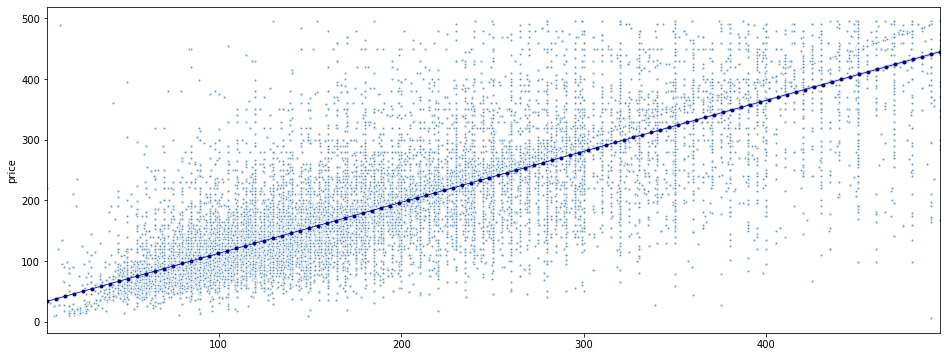

In [ ]:
plt.figure(figsize=(16,6))
sns.regplot(y=y_test_nd,x=pred_nd,scatter_kws={"color": "steelblue","s":8,"edgecolors":"white", "marker":"+"}, line_kws={'lw': 0.7, "color": "darkblue", "marker":"."})

**3. Comparación con Vecinos más cercanos**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

In [ ]:
#Entrenamiento para los dos datasets
#New dataset
knn.fit(X_train_nd, y_train_nd)
pred_nd = knn.predict(X_test_nd)
#Dataset del royecto 1 
knn.fit(X_train_ml, y_train_ml)
pred_ml = knn.predict(X_test_ml)


#Métricas de evaluación de modelos
error_nd = round(mean_absolute_error(y_test_nd, pred_nd))
r2_nd = r2_score(y_test_nd, pred_nd)
rmse_nd=mean_squared_error(y_test_nd, pred_nd)

error_ml = round(mean_absolute_error(y_test_ml, pred_ml))
r2_ml = r2_score(y_test_ml, pred_ml)
rmse_ml=mean_squared_error(y_test_ml, pred_ml)

print("MAE con el nuevo dataset: "+str(error_nd)+ " dólares")
print("R2 con el nuevo dataset: "+str(r2_nd))
print("RMSE con el nuevo dataset: "+str(rmse_nd))
print("MAE con el dataset del proyecto 1: "+str(error_ml)+" dólares")
print("R2 con el dataset del proyecto 1: "+str(r2_ml))
print("RMSE con el dataset del proyecto 1: "+str(rmse_ml))

MAE con el nuevo dataset: 43 dólares
R2 con el nuevo dataset: 0.5686121194881889
RMSE con el nuevo dataset: 4079.0760320540753
MAE con el dataset del proyecto 1: 60 dólares
R2 con el dataset del proyecto 1: 0.7433840415905911
RMSE con el dataset del proyecto 1: 23402.05667225178


Comparando los resultados se puede observar que el error promedio de predicción con el dataset limpio en esta entrega mejora en 17 dólares. Sin embargo, la bondad de ajuste empeora en casi 0.18. No obstante el RMSE es mucho más alto en el dataset del proyecto 1. 

**Conclusión**

La limpieza de la base de datos puede influir en el desempeño de los modelos dado que le permite generalizar mucho mejor y desviarse menos del precio real. En el caso del nuevo dataset al categorizar las variables, limpiar outliers resulta mucho mejor que en el dataset anterior que tenía un universo más acotado y no contemplaba los missing values y fijaba un tope de precios estudiado.

**PARTE B - Modelos Avanzados**

**Consigna:**

1. Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.


2. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

3. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

**1. Random Forest** 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
X_ad = df3.drop(["price"], axis = 1)
y_ad = df3.price / 1000
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_ad, y_ad, train_size=0.8,test_size=0.2, random_state=42)

In [ ]:
#Entrenamiento
random_forest = RandomForestRegressor(random_state=0).fit(X_train_ad, y_train_ad)
pred_ad = random_forest.predict(X_test_ad)

#Métricas
error_ad = mean_absolute_error(y_test_ad, pred_ad)
r2_ad = r2_score(y_test_ad, pred_ad)
rmse_ad=mean_squared_error(y_test_ad, pred_ad)

print("MAE random forest: "+str(error_ad))
print("R2 random forest: "+str(r2_ad))
print("RMSE random forest: "+str(rmse_ad))

MAE random forest: 27.392689273952506
R2 random forest: 0.7950828384566657
RMSE random forest: 1937.6359883274065


In [ ]:
#Parámetros que está usando el modelo por default
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Usamos RandomizedSearchCV para ajustar los hiperparámetros del modelo
#Debería ser un poco más rápida que GridSearch, ya que no ejecuta todas las combinaciones, sino algunas al azar
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Número de árboles
n_estimators = [200, 500, 1000]
# Profundidad
max_depth = [10, 50, 100, None]
# Número mínimo de muestras necesarias para dividir un nodo interno
min_samples_split = [2, 5, 10]
# Número mínimo de muestras que deben estar en cada nodo de la hoja
min_samples_leaf = [1, 2, 4]
# Crear la grilla
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,}

random_forest_RS = RandomizedSearchCV(random_forest, random_grid, n_iter = 25, verbose=2, cv = 3, random_state=42, n_jobs = -1)

random_forest_RS.fit(X_train_ad, y_train_ad)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 59.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 104.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
print("Mejores parametros: "+str(random_forest_RS.best_params_))
print("Mejor Score: "+str(random_forest_RS.best_score_))

Mejores parametros: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Mejor Score: 0.7798621237159798


Con la optimización, se realiza la predicción del modelo nuevamente con su respectiva métrica de evaluación.

In [ ]:
pred_random_op = random_forest_RS.predict(X_test_ad)

#Métricas
error_random_op = mean_absolute_error(y_test_ad, pred_random_op)
r2_random_op = r2_score(y_test_ad, pred_random_op)
rmse_random_op=mean_squared_error(y_test_ad, pred_random_op)

print("MAE: "+str(error_random_op))
print("R2: "+str(r2_random_op))
print("RMSE: "+str(rmse_random_op))

MAE: 27.290026989135857
R2: 0.796904626462129
RMSE: 1920.4097005147944


Con la optimización, el modelo tiene una bondad de ajuste muy superior a los estimados en la Parte A. El error es de 27 dólares en promedio del precio normal y el RMSE es el más bajo calculado en todos los ejercicios. 

**2. XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
xgb_regressor = XGBRegressor(random_state=1).fit(X_train_ad, y_train_ad)

[15:13:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Predicción
pred_xgb = xgb_regressor.predict(X_test_ad)

#Métricas
error_xgb = mean_absolute_error(y_test_ad, pred_xgb)
r2_xgb = r2_score(y_test_ad, pred_xgb)
rmse_xgb=mean_squared_error(y_test_ad, pred_xgb)

print("MAE: "+str(error_xgb))
print("R2: "+str(r2_xgb))
print("RMSE: "+str(rmse_xgb))

MAE: 40.605968369905774
R2: 0.6622582995015058
RMSE: 3193.5854894534377


Comparado con los modelos estudiados en la Parte A, el desempeño es muy similar e inferior al Random Forest optimizado. El desempeño disminuye en cerca de 0.13.  El RMSE es sólo más alto que comparado con el Árbol de decisión.

**Optimización del XGBoost**

Al igual que con Random Forest se buscará la optimziación de hiperparámetros del modelo usando RandomSearchCV.

In [ ]:
# Cantidad de árboles
n_estimators = [50, 100, 150, 200]
# Profundidad 
max_depth = [2, 10, 50, None]
# Factor de contracción o tasa de aprendizaje
learning_rate = [0.05, 0.1, 0.3]

# Crear la grilla
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}

xgb_RS = RandomizedSearchCV(xgb_regressor, random_grid, n_iter = 10, verbose=2, cv = 3, random_state=42, n_jobs = -1)

xgb_RS.fit(X_train_ad, y_train_ad)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.5min finished


[15:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=1, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
pred_xgb_op = xgb_RS.predict(X_test_ad)

#Métricas
error_xgb_op = mean_absolute_error(y_test_ad, pred_xgb_op)
r2_xgb_op = r2_score(y_test_ad, pred_xgb_op)
rmse_xgb_op=mean_squared_error(y_test_ad, pred_xgb_op)

print("MAE: "+str(error_xgb_op))
print("R2: "+str(r2_xgb_op))
print("RMSE: "+str(rmse_xgb_op))

MAE: 29.118025817796862
R2: 0.7968552944633251
RMSE: 1920.8761692846062


Tras el uso de los mejores hierpámetros del modelo se obtiene un error promedio de 29,1 dólares. Asimismo la bondad de ajuste es muy cercana a la obtenida del modelo optimizado en Random Forest. No obstante, el RMSE es superior por 0,2 aproximadamente. 

En todo caso al comparar los modelos, por muy poco el random forest con los hiperparámetros optimizados a través de la grilla es mejor. Sin embargo, es importante considerar que en términos computacionales el Random Forest es mucho más demandante que XgBoost.

**Extra: Uso de HyperOpt**

Esta librería optimiza hiperparámetros y vale la pena utilizarla dadas sus bondades en eficiencia computacional lo que podría ejecutar la funcionalidad de RandomGridSearch puesto que realiza optimización bayesiana.

In [ ]:
pip install hyperopt

In [ ]:
pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-cn7hwehg
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-cn7hwehg
     |████████████████████████████████| 163kB 7.5MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-cp36-none-any.whl size=26923 sha256=385f1ca029c9227d752895401e69fa976077c5f8aeb77b024f826a250ef2f4e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ru3tp5m/wheels/41/1f/14/fd9ceae3ef0a227e2a6ea0a12b3c94202507000f48ca21c823
Successfully built hpsklearn


In [ ]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [ ]:
#Instanciamos un modelo
#Hyperopt va a buscar entre todos los algoritmos de regresión con los que cuenta y evaluarlos
#Se le puede poner un tiempo máximo para la evaluación, para que no sea tan tedioso el proceso

hyperop_regr = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), 
                            loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=120, verbose=True)

In [ ]:
#Entrenamiento
hyperop_regr.fit(X_train_ad, y_train_ad)

Will use the last 0.2 portion of samples for validation
Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True) to X of shape (86825, 9)
Limited PCA n_components at 9
Transforming Xfit (86825, 9)
Transforming Xval (21707, 9)
Training learner AdaBoostRegressor(base_estimator=None, learning_rate=0.24635545261073202,
                  loss='square', n_estimators=128, random_state=1) on X/EX of dimension (86825, 9)
Scoring on X/EX validation of shape (21707, 9)
OK trial with loss 89.9
100%|██████████| 1/1 [00:28<00:00, 28.24s/it, best loss: 89.90426763139244]
Will use the last 0.2 portion of samples for validation
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (86825, 9)
Transforming Xfit (86825, 9)
Transforming Xval (21707, 9)
Training learner KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=1, n_neighbors=45, p=2,
 

Ahora es posible encontrar el mejor modelo:

In [ ]:
print(hyperop_regr.best_model())

{'learner': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.010608477016125937,
                          loss='ls', max_depth=None,
                          max_features=0.29756469866254465, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=386,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=4, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}


In [ ]:
#Predicción
pred_hyperop = hyperop_regr.predict(X_test_ad)

#Métrica
error_hyperop = mean_absolute_error(y_test_ad, pred_hyperop)
r2_hyperop = r2_score(y_test_ad, pred_hyperop)
rmse_hyperop=mean_squared_error(y_test_ad, pred_hyperop)

print("MAE: "+str(error_hyperop))
print("R2: "+str(r2_hyperop))
print("RMSE: "+str(rmse_hyperop))

Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (27134, 9)
Transforming Xfit (27134, 9)
MAE: 28.28704185929606
R2: 0.7972119469491786
RMSE: 1917.5037690097276


Con esta librería se obtuvo el mejor modelo en todo el proyecto. El error promedio es de 27 dólares, la bondad de ajuste es la más alta pero esta mejora es mínima comparada con la optimización óptima de random forest y XGBoost. No obstante el RMSE es el más bajo de todos. El modelo seleccionado se denomina ExtraTreesRegressor. 

Esta clase implementa un metaestimador que se ajusta a varios árboles de decisión aleatorios (también conocidos como árboles extra) en varias submuestras del conjunto de datos y usa promedios para mejorar la precisión predictiva y controlar el sobreajuste.

En términos del tiempo en su cálculo, en tiempo es más rápido que el ejercicio realizado para Random Forest con RandomGridSearch, no obstante el más rápido de los tres es el cálculo de la optimización del XGBoost.

**Elección de modelos**

Tras realizar todos los ejercicios con Random Forest, XGBoost y el adicional utilizando Hyperopt que es el modelo ExtraTreesRegressor, el mejor modelo es el optimizado con XGBoost. La bondad de ajuste de este modelo es superior a los estimados en la Parte A, al igual que las métricas de MAE y RMSE. 

A pesar del gran poder que tiene ExtraTreesRegressor el costo en tiempo por una mejora que no es tan amplia no justifica su elección. No obstante y dado su mejor comportamiento se realizará la parte C del proyecto con este modelo, que además permite tener un mayor conocimiento sobre un modelo no estudiado en clase. 

**PARTE C - Interpretación de modelos**

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:



*   ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. 
*   ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?





In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

extratrees_regressor = ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse', max_depth=None, max_features=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=523, n_jobs=1, oob_score=False, random_state=3,
                    verbose=False, warm_start=False).fit(X_train_ad, y_train_ad)             
                    



In [ ]:
#Predicción
pred_extratree = extratrees_regressor.predict(X_test_ad)

#Métrica
error_extratree = mean_absolute_error(y_test_ad, pred_extratree)
r2_extratree = r2_score(y_test_ad, pred_extratree)
rmse_extratree=mean_squared_error(y_test_ad, pred_extratree)

print("MAE: "+str(error_extratree))
print("R2: "+str(r2_extratree))
print("RMSE: "+str(rmse_extratree))

MAE: 27.148875412202123
R2: 0.8019610810868795
RMSE: 1872.5973631757909


Ahora se determinará la importancia de features

In [ ]:
#Features
features_nombre = X_train_ad.columns

importances = extratrees_regressor.feature_importances_[:]

listado_importancias = np.argsort(importances) #Le da el orden a las importancias




La gráfica a continuación permite ver el listado de importancia de mayor a menor con su respectiva importancia relativa en el modelo. La variable más relevante en el modelo son los baños, seguida por el barrio y la superficie cubierta. 

Los baños son una señal propia del tipo de propiedad que puede estar capturando con mayor facilidad el precio de la misma y este puede ser un factor determinante que debe alinearse con la superficie cubierta. 

De la hipótesis que se tuvo cuando se le realizó el encode al barrio se supuso que era relevante y resultó ser comprobada. Por otro lado las variables creadas como la diferencia de días y los adjetivos de para describir la propiedad no son los factores más relevantes en el precio y más bien en el caso de los adjetivos no influyen en el precio pero si podrían influir en que las personas se interesen más en la propiedad. 

Por otro lado, la diferencia en días desde la publiación y efectiva venta de la propiedad no determina el precio como se planteó al crear esta variable. 


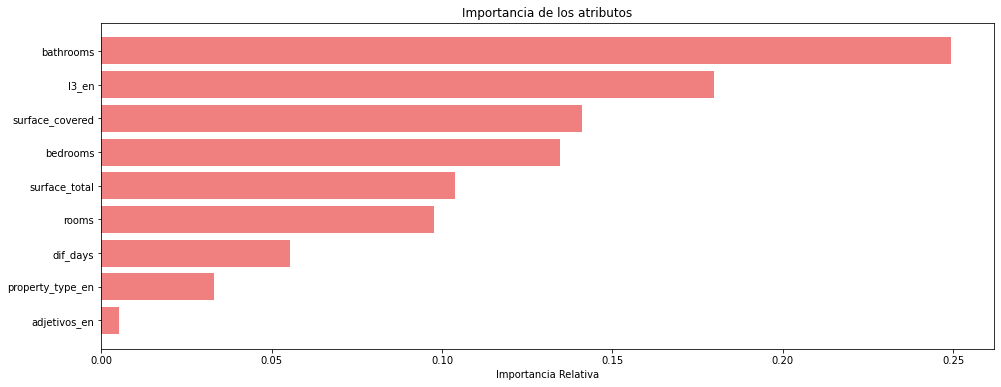

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Importancia de los atributos')
plt.barh(range(len(listado_importancias)), importances[listado_importancias], color='lightcoral', align='center')
plt.yticks(range(len(listado_importancias)), [features_nombre[i] for i in listado_importancias])
plt.xlabel('Importancia Relativa')
plt.show()

Siguiendo la consigna, dado que extratrees es un árbol, se elegirán al azar 10 para determinar cómo varía la importancia de los features. 

Del ejercicio se puede observar que la importancia se rota entre el número de baños, como se observó en el general, número de habitaciones y el barrio. Al tomar de manera aleatoria el orden de importancias dada su importancia relativa, se puede observar que cada árbol está aportando información similar y que es coherente con la general como se ha mencionado. 

El ejercicio permite tener una mayor certeza del resultado completo. Además en todos los casos el feature que menos importa es igual que es el de los adjetivos. 

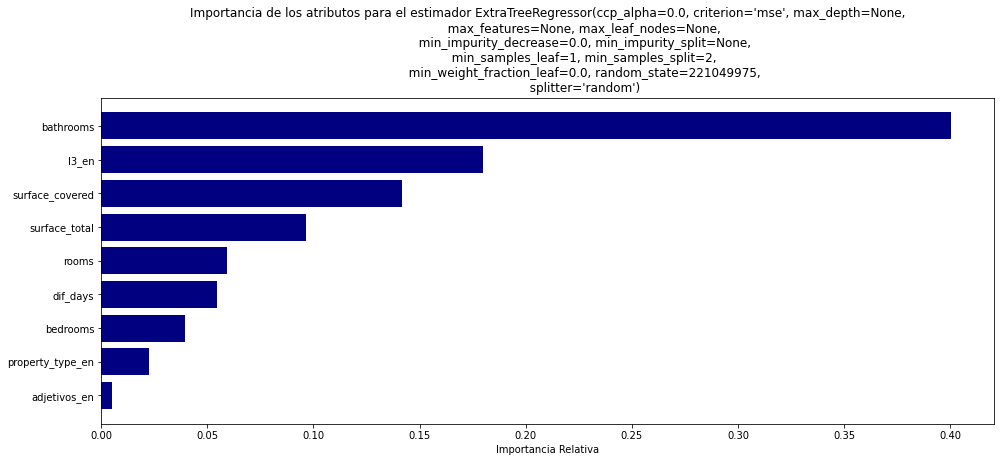

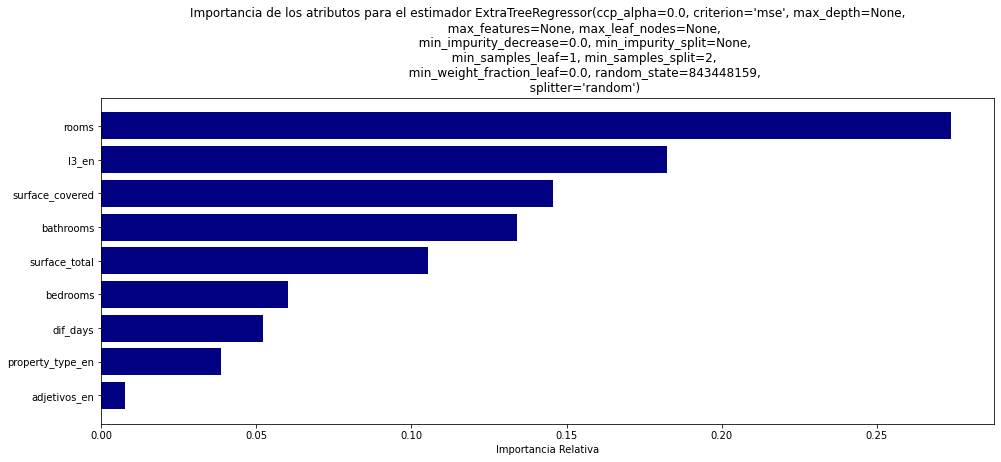

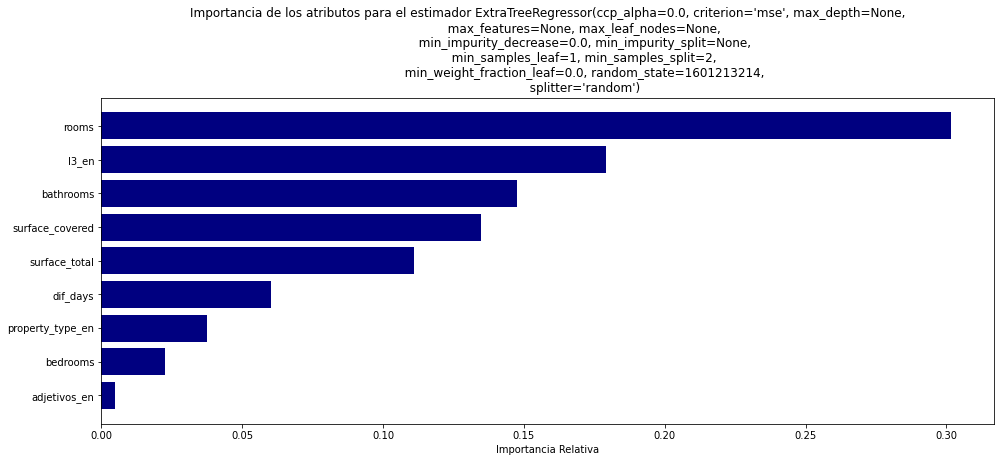

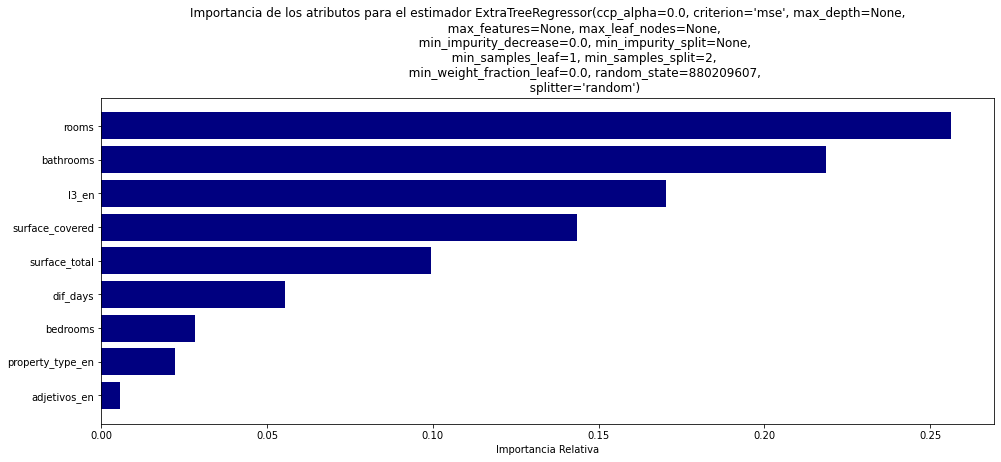

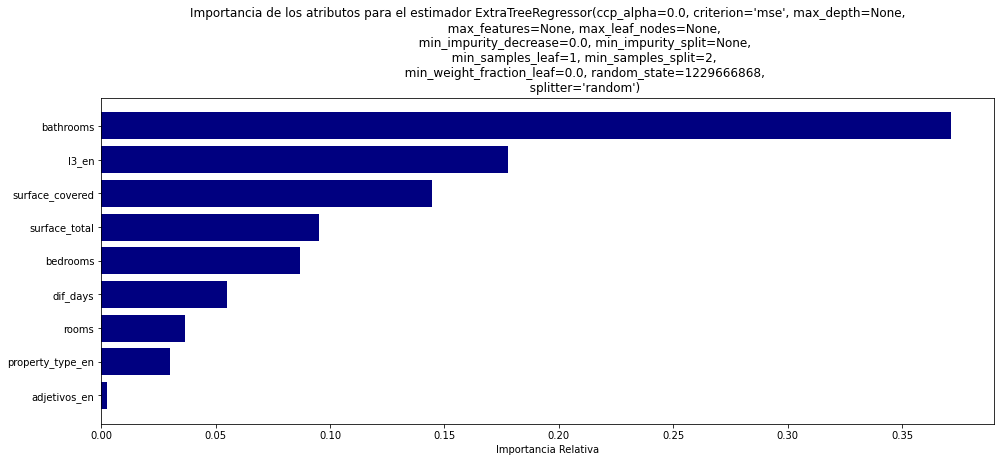

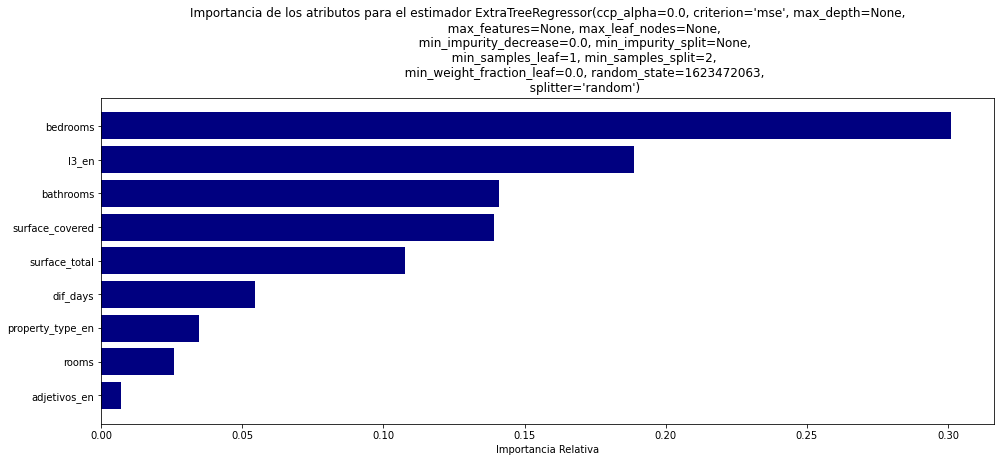

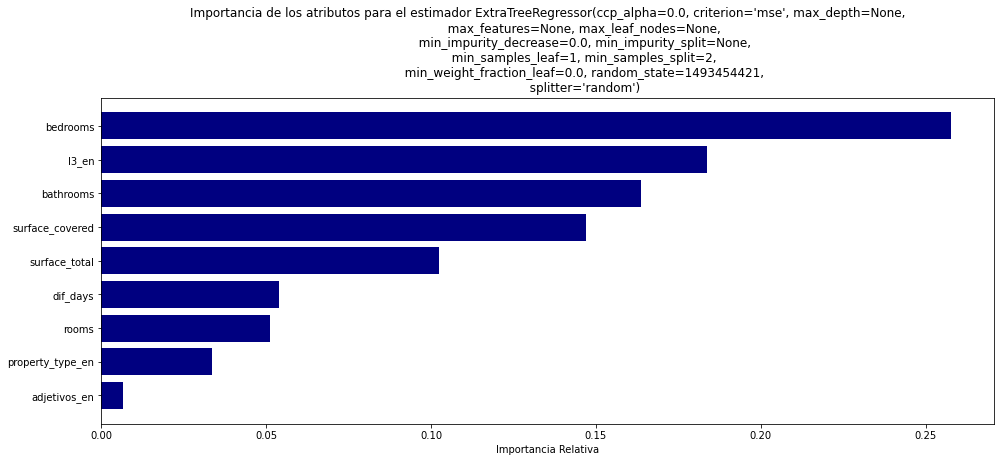

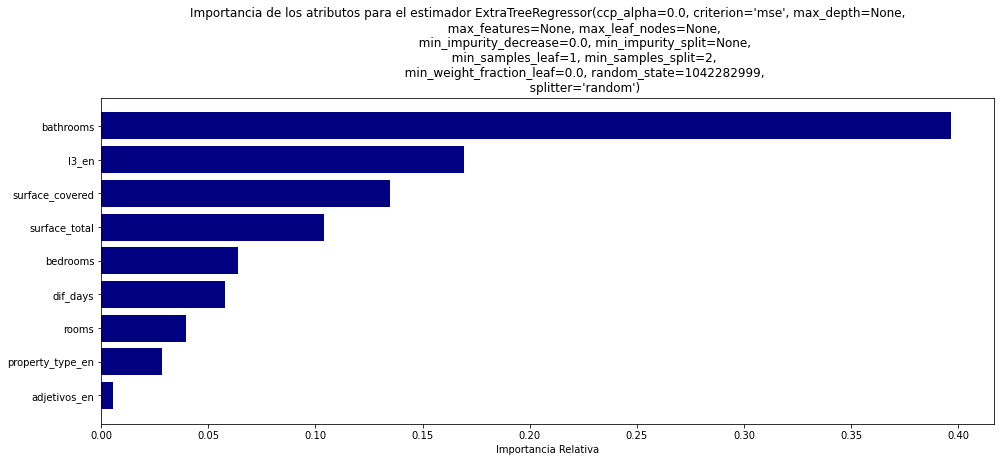

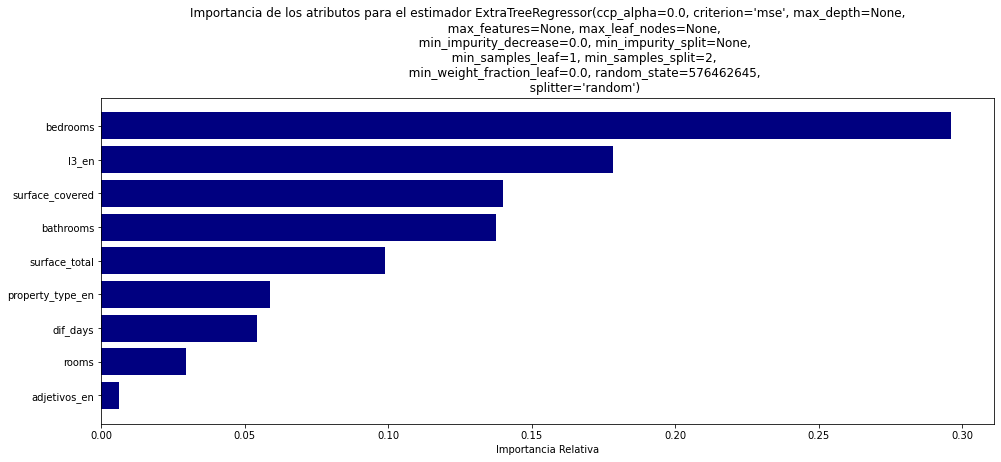

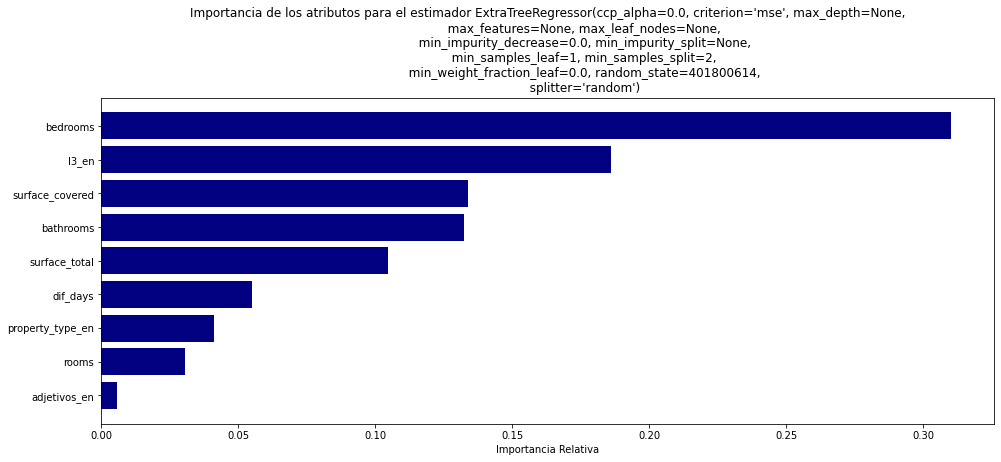

In [ ]:
estimadores_extratrees = extratrees_regressor.estimators_

estimador_aleatorio = np.random.choice(estimadores_extratrees, size=10, replace=False)

for estimador in estimador_aleatorio:
    importances = estimador.feature_importances_[:] #Se capturan todas las columnas
    listado_importancias = np.argsort(importances)
    plt.figure(figsize=(16,6))
    plt.title('Importancia de los atributos para el estimador '+ str(estimador))
    plt.barh(range(len(listado_importancias)), importances[listado_importancias], color="navy", align='center')
    plt.yticks(range(len(listado_importancias)), [features_nombre[i] for i in listado_importancias])
    plt.xlabel('Importancia Relativa')
    plt.show()

Tras estudiar la importancia de los atributos y su importancia relativa, es importante analizar los errores del modelo. La gráfica a continuación muestra que hay errores que son outliers pero en general el error se ajusta como se puede observar en la sección que ajusta a la línea roja. Además tiene una distribución normal que se encuentra muy concentrada en cero, mostrando que hay un ajuste importante en donde el error predicho con el modelo de extratree no discrepa de forma significativa del precio real.

Este resultado es coherente con las métricas de evaluación de este modelo, en donde el MAE muestra este resultado. 

El mayor error se da entre -300 o 300 de acuerdo con la gráfica pero hay muy pocas observaciones concentradas allí, coherente con la distribución normal del error que se calcula con el precio real y el predicho. 

In [ ]:
from scipy import stats

error_calculado = y_test_ad - pred_extratree 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


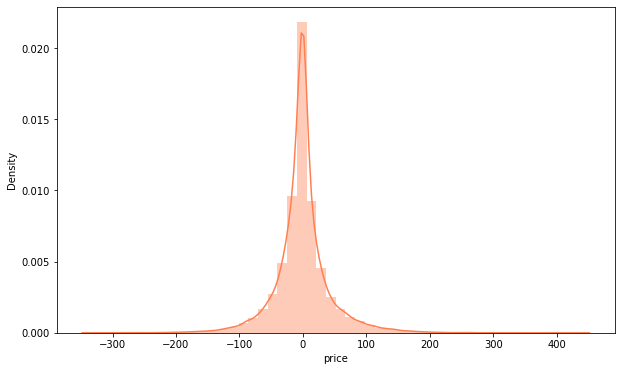

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(error_calculado, color="coral")

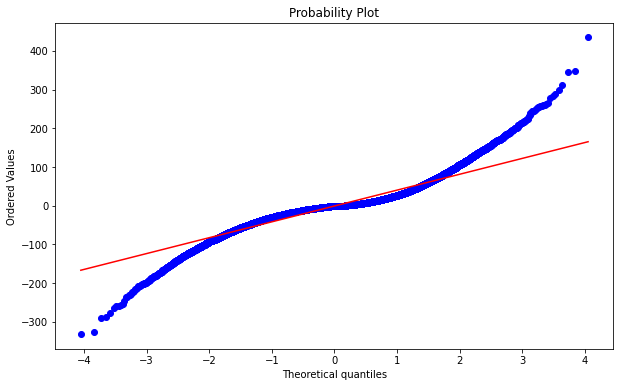

In [ ]:
plt.figure(figsize=(10,6))
ax=stats.probplot(error_calculado, dist="norm", plot=plt)


**Conclusiones del Proyecto 2**

Tras todo el ejercicio se denota la importancia de la limpieza de datos con todos los pasos propuestos, el tratamiento de los missings y su imputación, el control de los outliers y la importancia de las variables que se pueden volver en numéricas tras hacer un encoding a la categoría. 


Como se propuso al inicio del ejercicio, se estimó una serie de variables que podrían ser de utilidad: diferencia en días y los adjetivos utilizados para describir las propiedades. No obstante la inclusión de estas variables no tuvo el efecto deseado en donde las avriables que ya estaban en el dataset tuvieron un papel protagónico y eso se denota en el análisis de importancia. 

Por otro lado, el encoding es clave y se esperaba que el barrio tuviera un impacto importante en el precio. Tradicionalmente hay barrios más costosos que otros, en el caso de Colombia en donde hay una separación de estratros, hay barrios tradicionalmente más costosos en donde las personas más acomodadas tienen sus propiedades, allí el costo de los servicios públicos es superior y tienen unas condiciones de entorno (parques, centros comerciales, colegios, entre otros) con mayor acceso a barrios que tienen estratos más bajos o que tradicionalmente son más económicos. 

Al realizar este encode se rescató esta hipótesis y se corroboró en donde se pudo notar que efectivamente era una variable importante a tomar en cuenta para predecir el precio de la vivienda. 

Los missing values y los outliers permiten llevar a una base de datos más limpia en donde es posible lograr un ejercicio más prolijo en donde los modelos tienen una mejor capacidad para generalizar y predecir. 

Ahondando en los modelos, en la Parte A, la relevancia de tener una base de datos más procesada y tratada con más minucia arroja mejores resultados en los modelos, medido en este caso por métricas de MAE, R2 (coeficiente de determinación) y RMSE. 

Ya en la Parte B es posible ver el sacrificio computacional versus el resultado obtenido de dos modelos: Random Forest, XGBoost que funciona bajo la lógica de gradiente.Estos dos modelos arrojaron mejores resultados de predicción comparado con los utilizados en la Parte A por lo que muestra la gran habilidad de estos modelos avanzados. Por otro lado, al realizar la optimización de hiperparámetros se encuentra una variable adicional a contemplar para el data scientist y es el tiempo que demora. La optimización por RandomGridSearch toma mas tiempo en Random Forest que en XGBoost, no obstante tras el uso de los modelos con estos hiperparámetros la mejora es importante pero comparada entre Random Forest y XGBoost no hay una mejora significativa por lo que se podría atender al que menos tiempo tome y el resultado sería satisfactorio. 

Finalmente, usando hyperopt, se hizo la búsqueda del mejor modelo y los hiperparámetros para el dataset propuesto. En este se encontró un modelo que es un poco superior a los dos anteriores y es ExtraTreesRegressor. 

Con este último se realizó el ejercicio de importancias que arrojó los resultados ya mencionados. Tomando de forma aleatoria los distintos árboles que lo conforman, se encontró consistencia en la importancia de los atributos para predecir el precio de las propiedades. 

*¿Qué falta por mejorar? ¿Qué agregaría más valor al ejercicio?*

El modelo se puede mejorar incorporando más información que permita enriquecer el dataset, además se puede estudiar la posibilidad de hacer un ejercicio separado por tipo de propiedad que permita tener mayor certeza y mayor pureza del ejercicio. Cada tipo de propiedad se define de forma distina, un departamento o una casa que son propiedades para habitar son distintas en su uso e interés en ubicación y superficie cubierta y otras amenidades que las de las de oficinas. 

En el caso específico de inclusión de un análisis teniendo en cuenta la temporalidad es relevante. El precio de la vivienda también se encuentra atado a factores económicos, cuando una economía se encuentra en bonanza los precios son mucho mayores a los que se encuentran cuando la economía está en recesión y la necesidad de liquidez de los propietarios de vivienda se convierte en una prioridad y los precios pueden ser distintos. 

El ejercicio incorporando una serie de tiempo de viviendas puede resultar poderoso para mostrar dinámicas del sector de construcción que reacciona con los factores económicos y que además es un sector relevante para reactivar la actividad económica en un momento de crisis. Este tipo de ejercicios permite incorporar mayores usos como toma de decisiones a nivel macroeconómico. 

